# 1. Getting VizDoom Up and Running

In [2]:
!pip install vizdoom

In [2]:
!cd github & git clone https://github.com/mwydmuch/ViZDoom.git

Cloning into 'ViZDoom'...
Updating files:  25% (517/2040)
Updating files:  26% (531/2040)
Updating files:  27% (551/2040)
Updating files:  28% (572/2040)
Updating files:  29% (592/2040)
Updating files:  30% (612/2040)
Updating files:  31% (633/2040)
Updating files:  32% (653/2040)
Updating files:  33% (674/2040)
Updating files:  34% (694/2040)
Updating files:  35% (714/2040)
Updating files:  36% (735/2040)
Updating files:  37% (755/2040)
Updating files:  38% (776/2040)
Updating files:  39% (796/2040)
Updating files:  40% (816/2040)
Updating files:  41% (837/2040)
Updating files:  42% (857/2040)
Updating files:  43% (878/2040)
Updating files:  44% (898/2040)
Updating files:  45% (918/2040)
Updating files:  46% (939/2040)
Updating files:  47% (959/2040)
Updating files:  48% (980/2040)
Updating files:  49% (1000/2040)
Updating files:  50% (1020/2040)
Updating files:  51% (1041/2040)
Updating files:  52% (1061/2040)
Updating files:  53% (1082/2040)
Updating files:  54% (1102/2040)
Updating

In [1]:
# Import vizdoom for game env
from vizdoom import *
# Import random for action sampling
import random
# Import time for sleeping
import time
# Import numpy for identity matrix
import numpy as np

In [2]:
# Set up game
game = DoomGame()
game.load_config("github/VizDoom/scenarios/basic.cfg")
game.init()

In [3]:
# This is the set of actions that can be taken in the environment
actions = np.identity(3, dtype=np.uint8)

In [10]:
# Loop through episodes
episodes = 1
for episode in range(episodes):
    # Create a new episode/game
    game.new_episode()
    # Check the game isn't done
    while not game.is_episode_finished():
        # Get the game state
        state = game.get_state()
        # Get the game image
        img = state.screen_buffer
        # Get the game variables - ammo
        info = state.game_variables
        # Take an action
        # Second argument "skips 4 frames", giving reward 4 frames later
        #   Need this because when shooting, bullet doesn't immediately hit mob
        reward = game.make_action(random.choice(actions), 4)
        # Print reward
        print("Reward: ", reward)
        time.sleep(0.02)
    print("Result: ", game.get_total_reward())
    time.sleep(2)

Reward:  -4.0
Reward:  -4.0
Reward:  -4.0
Reward:  -4.0
Reward:  -4.0
Reward:  -9.0
Reward:  -4.0
Reward:  -4.0
Reward:  -4.0
Reward:  -4.0
Reward:  -9.0
Reward:  -4.0
Reward:  -4.0
Reward:  -4.0
Reward:  97.0
Reward:  -1.0
Result:  30.0


In [4]:
game.close()

# 2. Converting it to a Gym Environment

In [12]:
!pip install gym

In [2]:
# Import environment base class from OpenAI Gym
from gym import Env
# Import gym spaces
from gym.spaces import Box, Discrete
# Import opencv
import cv2

In [3]:
# Create ViZDoom OpenAI Gym Environment
class ViZDoomGym(Env):
    # Function that is called when we start the env
    def __init__(self, render=False):
        # Inherit from Env
        super().__init__()
        
        # Set up the game
        self.game = DoomGame()
        self.game.load_config("github/VizDoom/scenarios/basic.cfg")
        
        # Render frame logic
        self.game.set_window_visible(render)
        
        # Start the game
        self.game.init()
        
        # Create the action space and observation space
        self.action_space = Discrete(3)
        self.observation_space = Box(low=0, high=255, shape=(100,160,1), dtype=np.uint8)

    # This is how to take a step in the environment
    def step(self, action):
        actions = np.identity(3, dtype=np.uint8)
        reward = self.game.make_action(actions[action], 4)
        
        state = self.game.get_state()
        
        # Get all the information needed to be returned
        if state:
            img = state.screen_buffer
            img = self.grayscale(img)
            info = state.game_variables
            info = {"ammo":info[0]}
        else:
            img = np.zeros(self.observation_space.shape)
            info = {"ammo":0}

        done = self.game.is_episode_finished()
        
        return img, reward, done, info
    
    # Define how to render the game or environment
    def render(self):
        pass
    
    # Start a new game
    def reset(self):
        self.game.new_episode()
        img = self.game.get_state().screen_buffer
        return self.grayscale(img)
    
    # Grayscale the game frame and resize it
    def grayscale(self, observation):
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        img = np.reshape(resize, (100,160,1))
        return img
    
    # Close down the game
    def close(self):
        self.game.close()

In [189]:
env = ViZDoomGym(render=True)

In [164]:
state = env.reset()
state.shape

(100, 160, 1)

In [4]:
# Import Environment checker
from stable_baselines3.common import env_checker

In [5]:
env_checker.check_env(env)

NameError: name 'env' is not defined

# 3. View Game State

In [137]:
!pip install matplotlib

In [6]:
from matplotlib import pyplot as plt

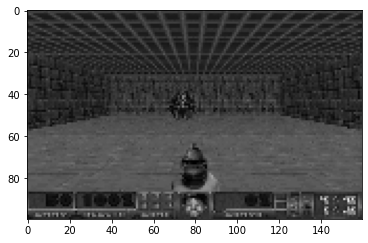

In [167]:
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))

In [38]:
env.close()

# 4. Setup Callback

In [170]:
!pip install torch torchvision torchaudio

In [173]:
!pip install stable-baselines3[extra]

In [7]:
# Import os for file nav
import os
# Import callback class for sb3
from stable_baselines3.common.callbacks import BaseCallback

In [19]:
class TrainAndLoggingCallback(BaseCallback):
    
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, "best_model_2048steps_{}".format(self.n_calls))
            self.model.save(model_path)

        return True

In [20]:
CHECKPOINT_DIR = "./train/train_basic"
LOG_DIR = "./logs/log_basic"

In [21]:
callback = TrainAndLoggingCallback(check_freq=100000, save_path=CHECKPOINT_DIR)

# 5. Train Model

In [11]:
# Import PPO for training
from stable_baselines3 import PPO

In [12]:
# Non-rendered environment
env = ViZDoomGym()

In [213]:
env.close()

In [14]:
model = PPO("CnnPolicy", env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=1e-4, n_steps=2048)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [16]:
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/log_basic\PPO_4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.3     |
|    ep_rew_mean     | -63.2    |
| time/              |          |
|    fps             | 82       |
|    iterations      | 1        |
|    time_elapsed    | 24       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25.7        |
|    ep_rew_mean          | -40         |
| time/                   |             |
|    fps                  | 33          |
|    iterations           | 2           |
|    time_elapsed         | 120         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.006823791 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 2.92e-06  

# 6. Test Model

In [23]:
# Import eval policy to test agent
from stable_baselines3.common.evaluation import evaluate_policy

In [26]:
# Reload model from disk
model = PPO.load("./train/train_basic/best_model_2048steps_100000", env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [28]:
# Create rendered environment
env = ViZDoomGym(render=True)

In [34]:
# Evaluate mean reward for 10 games
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=100)
print(mean_reward)

88.17


In [37]:
num_episodes = 5
for episode in range(num_episodes):
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        time.sleep(0.2)
        total_reward += reward
    print("Total reward for episode {}: {}".format(episode, total_reward))
    time.sleep(2)

Total reward for episode 0: 95.0
Total reward for episode 1: 95.0
Total reward for episode 2: 71.0
Total reward for episode 3: 95.0
Total reward for episode 4: 95.0
